In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np # linear algebra

import os # path processing
from mnist import MNIST # mnist file reader
from time import perf_counter # timer

## File Loader

In [2]:
file_loc = os.path.abspath('')

mnistdt = MNIST(file_loc +'./mnistdb')
img_arr_test, lb_arr_test = mnistdt.load_testing()
img_arr_train, lb_arr_train = mnistdt.load_training()

In [5]:
# image view
def resize(img):
    return np.reshape(img, [-1, 28, 28, 1])

def image_show(a):
    some_digit = a
    some_digit_image = some_digit.reshape(28,28)
    plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
    plt.axis("off")

# data fomater
def normalize(X):
    return X/255

# def onehot_encoding(y):
#     return np.eye(np.max(y)+1)[y]

# def add_bias(X):
#     return np.insert(X, 0, 1, axis=1)

In [23]:
# Image array to take a look
img_test = resize(img_arr_test)
img_train = resize(img_arr_train)

# ds - distributer
X_train =  normalize(np.array(img_arr_train))
X_test = normalize(np.array(img_arr_test))
y_train = np.array(lb_arr_train)
y_test = np.array(lb_arr_test)

Hien thi hinh anh trong x_train


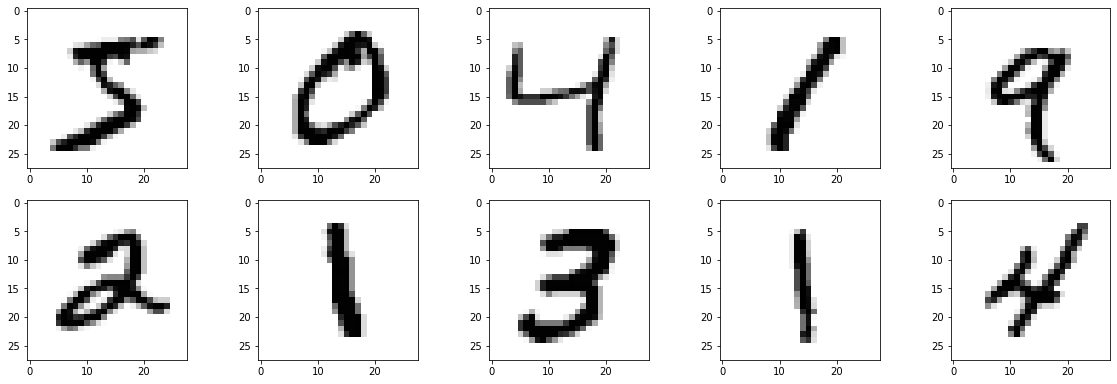

In [7]:
fig = plt.figure(figsize=(20,10))
def image_show(data, i):

    ax = fig.add_subplot(3, 5, i+1)
    data_image = data.reshape(28,28)
    ax.imshow(data_image, cmap = plt.cm.binary)   
    plt.axis()

print('Hien thi hinh anh trong x_train')
for i in range(10): 
    image_show(X_train[i], i)

## Logging, Visualizing and Saving model system

In [8]:
from datetime import datetime
class log:
    def __init__ (self, name = "temp.txt"):
        self.time = datetime.now()
        self.file_timeformat = self.time.strftime("%d-%m-%Y_%H-%M-%S_")
        self.filename = os.path.join(os.path.abspath("./logs/"), self.file_timeformat + name)
        self.file = open(self.filename, "w+")
    
    def write(self, text):
        self.file.write(text)
    
    def writel(self, text):
        self.file.write("\n" + text)

    def close(self):
        self.file.close()

In [22]:
# save the model to disk
import pickle # save train model
def save_model(obj, filename):
    filename = os.path.join(os.path.abspath('./pretrain_models/'), filename + ".sav")
    pickle_file = open(filename, 'wb')
    pickle.dump(obj, pickle_file)
    pickle_file.close()

def load_model(filename):
    file_path = os.path.join(os.path.abspath('./pretrain_models/'), filename)
    loaded_model = pickle.load(open(file_path, 'rb'))
    return loaded_model

In [34]:
# Visualize data
def Visualize(loss_train, acc_train, loss_test, acc_test, filename):
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(loss_train, 'tab:red')
    axs[0, 0].set_title('Loss train')
    axs[0, 1].plot(acc_train, 'tab:green')
    axs[0, 1].set_title('Acc train')
    axs[1, 0].plot(loss_test, 'tab:red')
    axs[1, 0].set_title('Loss test')
    axs[1, 1].plot(acc_test, 'tab:green')
    axs[1, 1].set_title('Acc test')
    fig.tight_layout()
    file_path = plt.savefig(os.path.join(os.path.abspath("./plots/"), filename))
    print('save plot thanh cong')

## Classification System:

In [12]:
class Model:
    
    def __init__(self, n_iter=100, learning_rate = 1.0, step_print = 10, is_break=0.0001,  n_slice = 1000, is_slice = True, filename = 'test.txt'):
        """
          param: 
              n_iter: so vong lap
              learning_rate: 0.0001
              step_print: Khoang cach so lan in 
              is_break: Dieu kien dung cua weight
              alpha: 1.0
              n_slice: So du lieu duoc cat
              is_clice: return True, False (co cat data hay khong?)
        """
        self.n_iter = n_iter
        self.is_break = is_break
        self.step_print = step_print
        self.learning_rate = learning_rate
        self.n_slice = n_slice
        self.is_slice = is_slice
        self.filename = filename
    
    def fit(self, X_train, y_train, X_test, y_test):
        np.random.seed(1024)
        self.classes = np.unique(y_train)
        self.n_classes = len(self.classes)
        X_train, y_train = self.ADCT(X_train, y_train)
        X_test, y_test = self.ADCT(X_test, y_test)
        self.loss_train= []
        self.acc_train = []
        self.loss_test = [] 
        self.acc_test = []
        self.weights = np.zeros(shape=(self.n_classes, X_train.shape[1]))  #(10x784) 
        self.gradient_descent(X_train, y_train, X_test, y_test)
        return self

    def ADCT(self, x, y):
        x = self.add_bias(x)  #CT trong giao trinh
        y = self.one_hot(y)   #CT trong giao trinh
        return x, y

    def gradient_descent(self, X_train, y_train, X_test, y_test):
        #print logs
        loger = log(self.filename)
        start = perf_counter()
        for i in range(self.n_iter):
            self.multinomial_logreg_error(X_train, y_train, X_test, y_test)
            
            if self.is_slice:
              #slice data
              idx = np.random.choice(X_train.shape[0], self.n_slice)
              X_slice, y_slice = X_train[idx], y_train[idx]
              grad = self.multinomial_logreg_grad_i(X_slice, y_slice)
            else:
              #full data
              grad = self.multinomial_logreg_grad_i(X_train, y_train)
            
            #update
            #overfit
            self.weights -= 1/X_train.shape[0] * self.learning_rate * (grad + (self.is_break/2 * np.linalg.norm(self.weights)) )
            
            if np.abs(grad).max() < self.is_break: 
                #stop
                break

            if i % self.step_print == 0: 
                #print message
                message = 'Loop {}/{},  Loss_train {},  Acc_train {}, Loss_test {}, Acc_test {}'.format(i+1,self.n_iter + 1 ,self.loss_train[i-1], self.acc_train[i-1], self.loss_test[i-1], self.acc_test[i-1])
                loger.writel(message)
                print(message)
        end = perf_counter()
        time = int(end) - int(start)
        loger.close()
        print('Save log')
        print('Chuong trinh chay mat: {} s'.format(time))


    def multinomial_logreg_error(self, X_train, y_train, X_test, y_test):
          self.loss_train.append(self.multinomial_logreg_loss_i(y_train, self.pro_predict(X_train)))
          self.acc_train.append(self.multinomial_logreg_total_grad(X_train, y_train))   #ghi vao file .txt
          self.loss_test.append(self.multinomial_logreg_loss_i(y_test, self.pro_predict(X_test)))
          self.acc_test.append(self.multinomial_logreg_total_grad(X_train, y_train))

    
    #*******************Part1********************#
    def multinomial_logreg_loss_i(self, y, probs):
        #cross_entropy
        return -np.mean(y * np.log(probs))

    def multinomial_logreg_grad_i(self, X, y):
        # cost function
        error = self.pro_predict(X) - y
        grad = np.dot(error.T, X)
        return grad
        
    def multinomial_logreg_total_grad(self, X, y):
        # evaluate check acc
        return np.mean(np.argmax(self.pro_predict(X), axis=1) == np.argmax(y, axis=1))

    def pro_predict(self, X):
        score = np.dot(X, self.weights.T).reshape(-1,len(self.classes))
        result = self.softmax(score)
        return result
    
    def softmax(self, score):
        # result: [0->1]
        return np.exp(score) / np.sum(np.exp(score), axis=1).reshape(-1,1)

    def predict_layer(self, X):
        X_add = self.pro_predict(self.add_bias(X))   #Xac suat
        return np.argmax(X_add, axis=1)

    def CheckModel(self, X, n_test):
        fig = plt.figure(figsize=(20,10))
        print('train thu {} data'.format(n_test))
        for i in range(n_test):
            ax = fig.add_subplot(3, 5, i+1)
            pos = np.random.randint(X.shape[0])
            ax.title.set_text('Dự đoán X_test[{}] la: {}'.format(pos, self.predict_layer(X)[pos]))
            ax.imshow(X_test[pos].reshape(28,28), cmap='gray')
            plt.axis()
    
    def sroce_pridict(self, X, y):
        return (np.mean(self.predict_layer(X) == y))
  
    def add_bias(self,X):
        return np.insert(X, 0, 1, axis=1)

    def one_hot(self, y):
        return np.eye(len(self.classes))[(y).reshape(-1)]

### Training Models

In [14]:
train_full = Model(is_slice=False, filename='train_full')
train_full.fit(X_train, y_train, X_test, y_test)
#Save model
save_model(train_full, "train_full")

Loop 1/101,  Loss_train 0.23025850929940433,  Acc_train 0.09871666666666666, Loss_test 0.23025850929940458, Acc_test 0.09871666666666666
Loop 11/101,  Loss_train 0.09345201065204362,  Acc_train 0.66565, Loss_test 0.09229631575692401, Acc_test 0.66565
Loop 21/101,  Loss_train 0.061401511641136386,  Acc_train 0.79285, Loss_test 0.059514184547001324, Acc_test 0.79285
Loop 31/101,  Loss_train 0.04669568436779759,  Acc_train 0.8634, Loss_test 0.04466074968718448, Acc_test 0.8634
Loop 41/101,  Loss_train 0.040607900201891534,  Acc_train 0.88775, Loss_test 0.038532529440792544, Acc_test 0.88775
Loop 51/101,  Loss_train 0.038797355925852,  Acc_train 0.89305, Loss_test 0.03679386718261033, Acc_test 0.89305
Loop 61/101,  Loss_train 0.0375620014762234,  Acc_train 0.89635, Loss_test 0.035652149899238005, Acc_test 0.89635
Loop 71/101,  Loss_train 0.03659235141266833,  Acc_train 0.8989, Loss_test 0.03477020380218264, Acc_test 0.8989
Loop 81/101,  Loss_train 0.03580022026651111,  Acc_train 0.9012, Lo

train thu 10 data
du doan dung  90.43166666666667 %


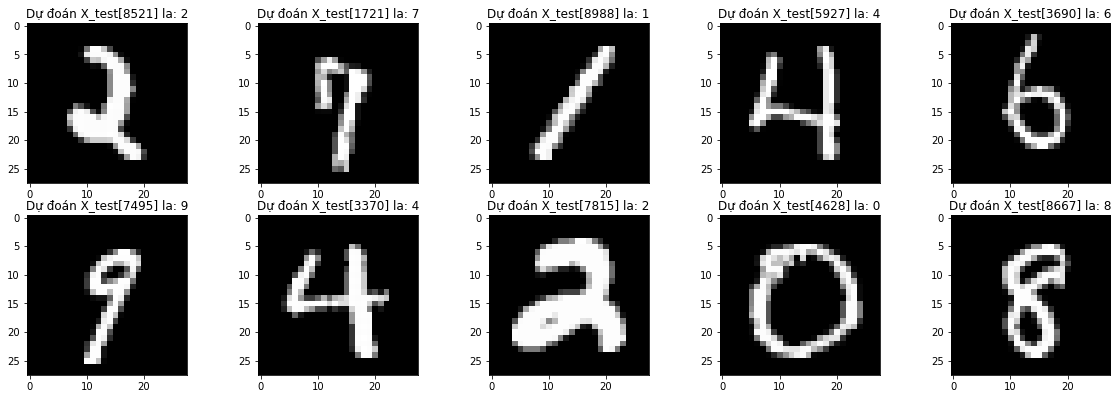

In [31]:
#Load model
train_full = load_model("train_full.sav")
train_full.CheckModel(X_test, 10)
print('du doan dung ', train_full.sroce_pridict(X_train, y_train)*100, '%')

save plot thanh cong


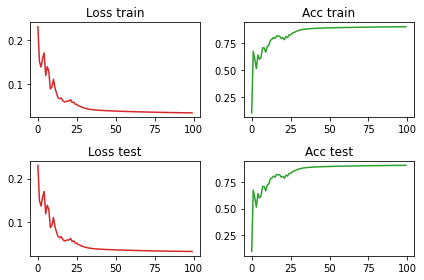

In [35]:
Visualize(train_full.loss_train, train_full.acc_train, train_full.loss_test, train_full.acc_test, "train_full")

In [26]:
# slice 100 data train
train_100 = Model(n_iter=100 , is_slice=True, step_print=10)
train_100.fit(X_train, y_train, X_test, y_test)
#Save model
save_model(train_100, "train_100")

Loop 1/101,  Loss_train 0.23025850929940433,  Acc_train 0.09871666666666666, Loss_test 0.23025850929940458, Acc_test 0.09871666666666666
Loop 11/101,  Loss_train 0.21507893045768686,  Acc_train 0.6971666666666667, Loss_test 0.21478608247196498, Acc_test 0.6971666666666667
Loop 21/101,  Loss_train 0.20025029978721298,  Acc_train 0.7358833333333333, Loss_test 0.19966613404096584, Acc_test 0.7358833333333333
Loop 31/101,  Loss_train 0.18707966769445253,  Acc_train 0.7441166666666666, Loss_test 0.18620992800779482, Acc_test 0.7441166666666666
Loop 41/101,  Loss_train 0.17553475654641912,  Acc_train 0.7565833333333334, Loss_test 0.17443482160532978, Acc_test 0.7565833333333334
Loop 51/101,  Loss_train 0.1653272637111592,  Acc_train 0.771, Loss_test 0.16404287085979266, Acc_test 0.771
Loop 61/101,  Loss_train 0.15629927511162608,  Acc_train 0.7755166666666666, Loss_test 0.15486772034685944, Acc_test 0.7755166666666666
Loop 71/101,  Loss_train 0.14826461141260983,  Acc_train 0.7849, Loss_test

train thu 10 data
du doan dung  79.83166666666666 %


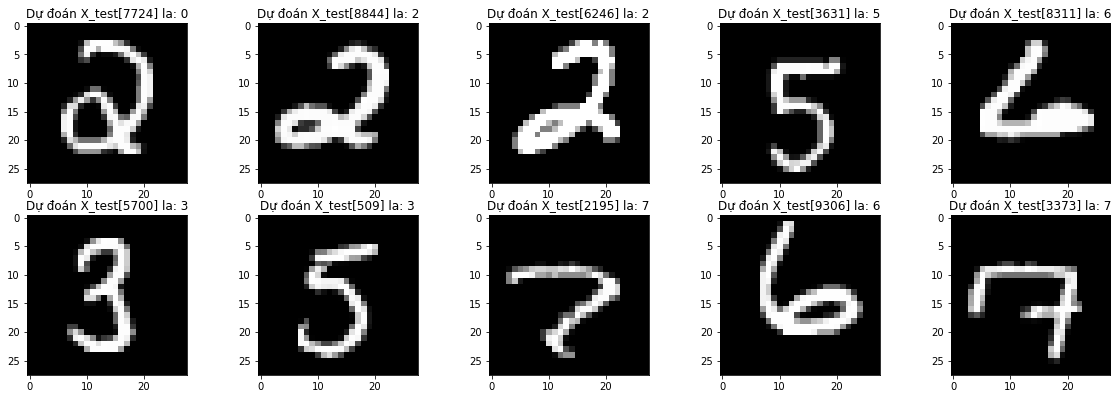

In [28]:
#Load model
train_100 = load_model("train_100.sav")
train_100.CheckModel(X_test, 10)
print('du doan dung ', train_100.sroce_pridict(X_train, y_train)*100, '%')

save plot thanh cong


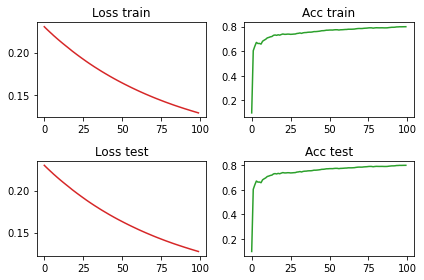

In [36]:
#Visualize
Visualize(train_100.loss_train, train_100.acc_train, train_100.loss_test, train_100.acc_test, "train_100")